<h1 style="text-align: center;">Lab 2</h1>
<h4 style="text-align: center;"><span style="text-decoration: underline">Submitted by :</span> BOULBEN Firdaous</h4>
<h4 style="text-align: center;"><span style="text-decoration: underline">Supervised by
:</span> Pr. EL AACHAK Lotfi</h4>


## Objective : 
The main purpose behind this lab is to get familiar with Pytorch library, to build 
neural architectures, CNN, RCNN, FCNN, Vit, etc for computer vision.

## Part 1: CNN Classifier

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score
import time

In [2]:
# Helper function for calculating metrics
def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    return accuracy, f1

### 1. CNN Model for MNIST Classification

In [3]:
# Define CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
subset_indices = list(range(0, len(mnist_dataset), 10))  # Use 10% of data
train_subset = Subset(mnist_dataset, subset_indices)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

train_loader_cnn = DataLoader(train_subset, batch_size=8, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17312255.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 466523.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3790952.44it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2502696.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Training Loop for CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

start_time_cnn = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    model_cnn.train()
    total_loss = 0
    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        optimizer_cnn.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        total_loss += loss.item()

    print(f"CNN - Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader_cnn):.4f}")
end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"Total CNN Training Time: {cnn_training_time:.2f} seconds")

CNN - Epoch [1/5], Loss: 0.5182
CNN - Epoch [2/5], Loss: 0.1535
CNN - Epoch [3/5], Loss: 0.1014
CNN - Epoch [4/5], Loss: 0.0785
CNN - Epoch [5/5], Loss: 0.0546
Total CNN Training Time: 15.95 seconds


In [6]:
# Evaluate CNN
model_cnn.eval()
true_labels, predictions = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

cnn_accuracy, cnn_f1 = calculate_metrics(true_labels, predictions)
print(f"CNN Accuracy: {cnn_accuracy:.4f}, F1 Score: {cnn_f1:.4f}")

CNN Accuracy: 0.9745, F1 Score: 0.9746


### 2. Faster R-CNN Model for Object Detection

In [7]:
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [8]:
# Initialize model
model_frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 10
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_frcnn = model_frcnn.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:04<00:00, 39.5MB/s] 


In [19]:
# Convert MNIST dataset to object detection format
def convert_to_detection_dataset(dataset):
    detection_data = []
    for image, label in dataset:
        boxes = torch.tensor([[0.0, 0.0, 28.0, 28.0]], dtype=torch.float32)  # Dummy box for entire image
        labels = torch.tensor([label], dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        detection_data.append((image, target))
    return detection_data

# Convert training data to detection format
detection_train_data = convert_to_detection_dataset(train_subset)
train_loader_frcnn = DataLoader(detection_train_data, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Convert test data to detection format (similar to training data)
detection_test_data = convert_to_detection_dataset(test_dataset)
test_loader_frcnn = DataLoader(detection_test_data, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [10]:
# Faster R-CNN Training Loop
optimizer_frcnn = optim.SGD(model_frcnn.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

start_time_frcnn = time.time()
for epoch in range(num_epochs):
    model_frcnn.train()
    total_loss = 0
    for images, targets in train_loader_frcnn:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer_frcnn.zero_grad()
        loss_dict = model_frcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer_frcnn.step()

        total_loss += losses.item()

    print(f"Faster R-CNN - Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader_frcnn):.4f}")
end_time_frcnn = time.time()
frcnn_training_time = end_time_frcnn - start_time_frcnn
print(f"Total Faster R-CNN Training Time: {frcnn_training_time:.2f} seconds")


Faster R-CNN - Epoch [1/5], Loss: 0.0380
Faster R-CNN - Epoch [2/5], Loss: 0.0130
Faster R-CNN - Epoch [3/5], Loss: 0.0096
Faster R-CNN - Epoch [4/5], Loss: 0.0080
Faster R-CNN - Epoch [5/5], Loss: 0.0074
Total Faster R-CNN Training Time: 5655.50 seconds


In [21]:
import numpy as np

# Evaluate Faster R-CNN
model_frcnn.eval()  # Set model to evaluation mode
true_labels, predictions = [], []

with torch.no_grad():  # Disable gradient calculation for inference
    for images, targets in test_loader_frcnn:
        images = [img.to(device) for img in images]  # Move images to device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

        # Perform inference (prediction)
        outputs = model_frcnn(images)

        for i, output in enumerate(outputs):
            # Filter out low-confidence predictions using a threshold (e.g., 0.5)
            high_confidence_boxes = output['scores'] > 0.5
            filtered_labels = output['labels'][high_confidence_boxes]
            
            # We want to store the true label and predicted label
            if len(filtered_labels) > 0:
                true_labels.append(targets[i]['labels'][0].item())  # True label from target
                predictions.append(filtered_labels[0].item())  # Predicted label with highest confidence

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Calculate Accuracy and F1 Score
frcnn_accuracy, frcnn_f1 = calculate_metrics(true_labels, predictions)

print(f"Faster R-CNN Evaluation - Accuracy: {frcnn_accuracy:.4f}, F1 Score: {frcnn_f1:.4f}")
 

Faster R-CNN Evaluation - Accuracy: 0.9709, F1 Score: 0.9641


### 3. Comparison of the two models  

In [22]:
# Display performance comparison
print("\nComparison of Models")
print("=====================")

# CNN metrics
print("\nCNN:")
print(f"Training Time: {cnn_training_time:.2f} seconds")
print(f"Accuracy: {cnn_accuracy:.4f}")
print(f"F1 Score: {cnn_f1:.4f}")

# Faster R-CNN metrics
print("\nFaster R-CNN:")
print(f"Training Time: {frcnn_training_time:.2f} seconds")
print(f"Accuracy: {frcnn_accuracy:.4f}")
print(f"F1 Score: {frcnn_f1:.4f}")


Comparison of Models

CNN:
Training Time: 15.95 seconds
Accuracy: 0.9745
F1 Score: 0.9746

Faster R-CNN:
Training Time: 5655.50 seconds
Accuracy: 0.9709
F1 Score: 0.9641


### 4. Fine-Tuning Pre-Trained Models for MNIST Classification  

#### 4.1. Preparing the MNIST Dataset for VGG16 and AlexNet  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for the training dataset (including grayscale to RGB conversion)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # Resize to match VGG16/AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

# Load MNIST dataset with the updated transformation
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader_pretrained = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36718804.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1168767.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10504789.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4404746.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### 4.2. Fine-Tuning VGG16 and AlexNet 

In [3]:
# Initialize pre-trained models (VGG16 and AlexNet)
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier[6] = nn.Linear(4096, 10)  # Update the classifier for 10 classes (MNIST)

model_alexnet = models.alexnet(pretrained=True)
model_alexnet.classifier[6] = nn.Linear(4096, 10)  # Update the classifier for 10 classes (MNIST)

# Move models to device (GPU or CPU)
model_vgg16.to(device)
model_alexnet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 201MB/s]  
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 4.3. Training Function

In [4]:
import time

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Function to train the model
def train_model(model, optimizer, criterion, train_loader, num_epochs):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the model
            
            epoch_loss += loss.item()  # Track loss
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")
    
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.4f} seconds")
    return training_time

#### 4.4. Training models   

In [5]:
# Train VGG16
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5
vgg16_training_time = train_model(model_vgg16, optimizer_vgg16, criterion, train_loader_pretrained, num_epochs)

Epoch [1/5], Loss: 0.0766
Epoch [2/5], Loss: 0.0239
Epoch [3/5], Loss: 0.0151
Epoch [4/5], Loss: 0.0113
Epoch [5/5], Loss: 0.0079
Training time: 6366.8824 seconds


In [6]:
# Train AlexNet
optimizer_alexnet = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)
alexnet_training_time = train_model(model_alexnet, optimizer_alexnet, criterion, train_loader_pretrained, num_epochs)

Epoch [1/5], Loss: 0.1003
Epoch [2/5], Loss: 0.0381
Epoch [3/5], Loss: 0.0249
Epoch [4/5], Loss: 0.0186
Epoch [5/5], Loss: 0.0155
Training time: 1126.7832 seconds


####   4.5. Evaluating models

In [7]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [10]:
# Evaluate VGG16
vgg16_accuracy = evaluate_model(model_vgg16, test_loader)

Accuracy: 0.9951


In [11]:
# Evaluate AlexNet
alexnet_accuracy = evaluate_model(model_alexnet, test_loader)

Accuracy: 0.9933


In [12]:
# Display the results
print(f"\nVGG16 Training Time: {vgg16_training_time:.4f} seconds")
print(f"VGG16 Accuracy: {vgg16_accuracy:.4f}")
print(f"AlexNet Training Time: {alexnet_training_time:.4f} seconds")
print(f"AlexNet Accuracy: {alexnet_accuracy:.4f}")


VGG16 Training Time: 6366.8824 seconds
VGG16 Accuracy: 0.9951
AlexNet Training Time: 1126.7832 seconds
AlexNet Accuracy: 0.9933


### 5. Conclusion
In conclusion, the choice of model depends on the specific needs of the task. **VGG16**, with its higher accuracy of 0.9951, is better when accuracy is the most important factor, though it requires much more time to train (6366.88 seconds). **AlexNet**, with a slightly lower accuracy of 0.9933 but much faster training time (1126.78 seconds), is a better choice when speed and efficiency are key. While **CNN** models with simpler structures may work well for lightweight tasks, they won’t match the accuracy of more complex models. **Faster R-CNN**, though not directly comparable in accuracy, excels in object detection tasks, making it a great choice for specialized use cases. Ultimately, the best model depends on whether accuracy, speed, or specific functionality like object detection is the priority.

## Part 2: Vision Transformer (VIT) 

### 1. Import Libraries and Set Random Seeds

In [33]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange

np.random.seed(0)
torch.manual_seed(0)

### 2. Patchify Images into Smaller Segments  

In [34]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

### 3. Define Multi-Head Self-Attention (MSA) Layer  

In [35]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

### 4. Create Vision Transformer Block (ViTBlock)  

In [36]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


### 5. Define Vision Transformer (ViT) Model Architecture  

In [37]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

### 6. Generate Positional Embeddings for Input Tokens  

In [40]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

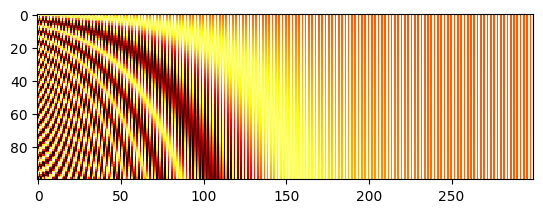

In [41]:
# Visualizing the Positional Embeddings with a Heatmap
if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

### 7. Train and Evaluate Vision Transformer on MNIST  

In [42]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(
        root="./../datasets", train=True, download=True, transform=transform
    )
    test_set = MNIST(
        root="./../datasets", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(
        "Using device: ",
        device,
        f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
    )
    model = MyViT(
        (1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
    ).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1} in training", leave=False
        ):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [43]:
if __name__ == "__main__":
    main()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 41730363.97it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1159104.51it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10608855.06it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3331094.38it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Using device:  cuda (Tesla T4)


Training:  20%|██        | 1/5 [05:47<23:09, 347.32s/it]              

Epoch 1/5 loss: 2.12



Training:  40%|████      | 2/5 [11:34<17:21, 347.18s/it]              

Epoch 2/5 loss: 1.86



Training:  60%|██████    | 3/5 [17:19<11:32, 346.30s/it]              

Epoch 3/5 loss: 1.76



Training:  80%|████████  | 4/5 [23:04<05:45, 345.87s/it]              

Epoch 4/5 loss: 1.70



Training: 100%|██████████| 5/5 [28:51<00:00, 346.25s/it]              


Epoch 5/5 loss: 1.68


Testing: 100%|██████████| 79/79 [00:32<00:00,  2.45it/s]

Test loss: 1.71
Test accuracy: 74.98%


### 8. Interpretation and Comparison of Results

The Vision Transformer (ViT) achieved **74.98% accuracy** and a test loss of **1.71** on MNIST, significantly lower than the CNN (**97.45% accuracy**) and Faster R-CNN (**97.09% accuracy**). ViTs are designed for large, complex datasets and struggle with small datasets like MNIST due to their lack of built-in inductive biases like locality and translation invariance, which CNNs exploit effectively.

While CNNs were the most efficient and accurate, Faster R-CNN also performed well but required substantially more training time. ViTs highlight their potential for large-scale tasks but are less suited to simpler datasets like MNIST without extensive tuning or additional data.